# Initialize system

In [1]:
### Setup the library ###
import pyrogue as pr
import os, sys
import matplotlib.pyplot as plt
import time
import datetime
import numpy as np
import math
import pprint
import inspect 
top_level=f'{os.getcwd()}/../'
rootTopLevel = top_level+'script/'
pr.addLibraryPath( rootTopLevel )

import setupLibPaths

import ePix320kM as devBoard

args = None

In [2]:
# ONLY RUN ONCE!
# Defining root
root =  devBoard.Root(   
        top_level  = rootTopLevel,
        dev        = '/dev/datadev_0',
        pollEn     = False,
        initRead   = True,
        serverPort = 9099)
root.start()

# example showing a read
AxiVersion = root.Core.AxiVersion
print ( '###################################################')
print ( '#             Firmware Version                    #')
print ( '###################################################')
AxiVersion.printStatus()
print ( '###################################################')

Root.Core.Si5345Pll.Page0.DataBlock.setPollInterval(1)
Start: Started zmqServer on ports 9099-9101
    To start a gui: python -m pyrogue gui --server='localhost:9099'
    To use a virtual client: client = pyrogue.interfaces.VirtualClient(addr='localhost', port=9099)
Root.Core.AxiVersion count reset called
###################################################
#             Firmware Version                    #
###################################################
Path         = Root.Core.AxiVersion
FwVersion    = 0x1000000
UpTime       = 8 days, 7:17:03
GitHash      = 0x69d8ea32115fd34d3ada6b89ad80fb3e63f2eda0
XilinxDnaId  = 0x400200000139d7204c80e045
FwTarget     = ePixHRM320k
BuildEnv     = Vivado v2022.1
BuildServer  = rdsrv314 (Ubuntu 20.04.6 LTS)
BuildDate    = Thu 24 Aug 2023 11:52:58 AM PDT
Builder      = dnajjar
###################################################


In [3]:
# Useful short names
APP  = root.App
AXIV = root.Core.AxiVersion
ASICTOP = APP.AsicTop
TRIG = ASICTOP.TriggerRegisters
ASIC0 = APP.Mv2Asic[0]
ASIC1 = APP.Mv2Asic[1]
ASIC2 = APP.Mv2Asic[2]
ASIC3 = APP.Mv2Asic[3]
HSDAC = APP.Dac.FastDac 
PKREG0 = ASICTOP.DigAsicStrmRegisters0
PKREG1 = ASICTOP.DigAsicStrmRegisters1
PKREG2 = ASICTOP.DigAsicStrmRegisters2
PKREG3 = ASICTOP.DigAsicStrmRegisters3
BATCHER0 = ASICTOP.BatcherEventBuilder0
BATCHER1 = ASICTOP.BatcherEventBuilder1
BATCHER2 = ASICTOP.BatcherEventBuilder2
BATCHER3 = ASICTOP.BatcherEventBuilder3
DEBUG0 = root._dbg[0]
DEBUG1 = root._dbg[1]
DEBUG2 = root._dbg[2]
DEBUG3 = root._dbg[3]
DATARCV0 = root.DataReceiver0
DATARCV1 = root.DataReceiver1
DATARCV2 = root.DataReceiver2
DATARCV3 = root.DataReceiver3
FULLRATERCV0 = root.fullRateDataReceiver[0]
FULLRATERCV1 = root.fullRateDataReceiver[1]
FULLRATERCV2 = root.fullRateDataReceiver[2]
FULLRATERCV3 = root.fullRateDataReceiver[3]
DAC = APP.Dac
REGCTRL = ASICTOP.RegisterControlDualClock

In [17]:
# Configure clock to 168 MHz and configures all ASICS
root.InitASIC([3,1,1,1,1])

Rysync ASIC started
Init ASIC script started
Loading PLL configuration
Root.Core.Si5345Pll.LoadCsvFile(): /u1/lorenzor/epix-hr-m-320k/software/notebook/../script/../config/EPixHRM320KPllConfig168Mhz.csv
Loaded. Waiting for lock...
Loading supply configuration
Loading /u1/lorenzor/epix-hr-m-320k/software/notebook/../script/../config/ePixHRM320k_PowerSupply_Enable.yml
Loading lane delay configurations
Loading /u1/lorenzor/epix-hr-m-320k/software/notebook/../script/../config/ePixHRM320k_SspMonGrp_carrier3.yml
Loading waveforms configuration
Loading /u1/lorenzor/epix-hr-m-320k/software/notebook/../script/../config/ePixHRM320k_RegisterControl.yml
Loading packet register configurations
Loading /u1/lorenzor/epix-hr-m-320k/software/notebook/../script/../config/ePixHRM320k_PacketRegisters.yml
Loading batcher configurations
Loading /u1/lorenzor/epix-hr-m-320k/software/notebook/../script/../config/ePixHRM320k_BatcherEventBuilder.yml
Taking asic off of reset
Loading ASICs and timing configuration


In [4]:
root.disableAndCleanAllFullRateDataRcv()
root.enableDataRcv(False)
root.enableDataDebug(False)

In [5]:
#run some triggers and exercise lanes and locks
frames = 1000
rate = 1000

root.hwTrigger(frames, rate)

Stop Triggers command executed
Set Auto Trigger command executed
Start Auto Trigger command executed
Triggers sent: 1000
Stop Triggers command executed


In [6]:
#get locked lanes
root.getLaneLocks()

ASIC0: 0xffffff
ASIC1: 0xfffffe
ASIC2: 0x36ffff
ASIC3: 0xffffff


In [22]:
#Disabled lanes in ASICS
for asicIndex in range(4) : 
    root.App.AsicTop.DigAsicStrmRegisters0.enable.set(True)
    print("ASIC{}: {:#x}".format(asicIndex, getattr(root.App.AsicTop, f"DigAsicStrmRegisters{asicIndex}").DisableLane.get()))

ASIC0: 0x2
ASIC1: 0x1
ASIC2: 0xc90000
ASIC3: 0x0


In [7]:
#Enable data receivers and run some triggers
root.enableDataRcv(True)
root.enableAllAsics(True)
root.Trigger()

descramble error
rawData length 24


In [8]:
# Obtain descrambled single frame data from ASICs from DataReceiver. Data receiver is down sampled.
root.printDataReceiverStatus()
    
frame = [None for i in range(4)]
for asicIndex in range(4):
    frame[asicIndex] = getattr(root, f"DataReceiver{asicIndex}").Data.get()

Checkpoint: DataReceiver 0 has 1 frames
Checkpoint: DataReceiver 1 has 1 frames
Checkpoint: DataReceiver 2 has 1 frames
Checkpoint: DataReceiver 3 has 1 frames


In [9]:
root.enableAsic(3, True)

# Lorenzo - Helper functions

In [10]:
%run dataProcFunctions.ipynb     #this is were my function was stored

In [11]:
# helper functions
# clock speed is 168MHz. 1 tick is 0.006 us
def setSR0(width, delay) :
    REGCTRL.SR0Delay1.set(delay)
    REGCTRL.SR0Width1.set(width)
    print(f'SR0 Width set to {REGCTRL.SR0Width1_us.get():.3f}uS')
    print(f'SR0 Delay set to {REGCTRL.SR0Delay_us.get():.3f}uS')
    
def setAcq1(width, delay) :
    REGCTRL.AcqDelay1.set(delay)
    REGCTRL.AcqWidth1.set(width)
    print(f'Acq1 Width set to {REGCTRL.AcqWidth1_us.get():.3f}uS')
    print(f'Acq1 Delay set to {REGCTRL.AcqDelay1_us.get():.3f}uS')
    
def setAcq2(width, delay) :
    REGCTRL.AcqDelay2.set(delay)
    REGCTRL.AcqWidth2.set(width)
    print(f'Acq2 Width set to {REGCTRL.AcqWidth2_us.get():.3f}uS')
    print(f'Acq2 Delay set to {REGCTRL.AcqDelay2_us.get():.3f}uS')    

def setR0(width, delay) :
    REGCTRL.R0Delay.set(delay)
    REGCTRL.R0Width.set(width)
    print(f'R0 Width set to {REGCTRL.R0Width_us.get():.3f}uS')
    print(f'R0 Delay set to {REGCTRL.R0Delay_us.get():.3f}uS') 

    
def setSync(width, delay) :
    REGCTRL.SyncDelay.set(delay)
    REGCTRL.SyncWidth.set(width)
    print(f'Sync Delay set to {REGCTRL.SyncDelay_us.get():.3f}uS')     

In [12]:
# Steps = clock period of 168Mhz (5.95ns)
# Acq1 is 20us
# R0 after Acq1
# R0 Width set to 1.920uS
# SR0 needs to be launched after R0 delay + R0 width + alpha



# ------------------- 20 us integration time
AcqWidth = 3125
AcqDelay = 260
setAcq1(AcqWidth, AcqDelay)

R0Width = 3425
R0Delay = 100
setR0(R0Width, R0Delay)

SR0Width = 38000
SR0Delay = R0Width + R0Delay + 10
setSR0(SR0Width, SR0Delay)

# ------------------- 1 us integration time
AcqWidth = 160
AcqDelay = 260
setAcq1(AcqWidth, AcqDelay)

R0Width = 3425
R0Delay = 100
setR0(R0Width, R0Delay)

SR0Width = 38000
SR0Delay = R0Width + R0Delay + 10
setSR0(SR0Width, SR0Delay)

# Print human-readable values
print(f'-------------------------')
baseline_int_time = REGCTRL.AcqDelay1_us.get() - REGCTRL.R0Delay_us.get()
integration_time = REGCTRL.AcqWidth1_us.get()
print(f'Baseline time:    {baseline_int_time} uS')
print(f'Integration time: {integration_time} uS')
print(f'Sampling done at: {REGCTRL.AcqWidth1_us.get()+REGCTRL.AcqDelay1_us.get()} uS')
print(f'-------------------------')

Acq1 Width set to 20.000uS
Acq1 Delay set to 1.664uS
R0 Width set to 21.920uS
R0 Delay set to 0.640uS
SR0 Width set to 226.190uS
SR0 Delay set to 21.042uS
Acq1 Width set to 1.024uS
Acq1 Delay set to 1.664uS
R0 Width set to 21.920uS
R0 Delay set to 0.640uS
SR0 Width set to 226.190uS
SR0 Delay set to 21.042uS
-------------------------
Baseline time:    1.024 uS
Integration time: 1.024 uS
Sampling done at: 2.6879999999999997 uS
-------------------------


# Set registers and variables

In [13]:
# Set some registers...
ASIC3.mTest.set(False)
ASIC3.CompTH_ePixM.set(0)
ASIC3.DHg.set(False)

# Optimal bias settings
ASIC3.RefinN.set(6)
ASIC3.RefinP.set(2)

# ASIC3.pipoclk_delay_row0.set(15)
# ASIC3.pipoclk_delay_row1.set(15)
# ASIC3.pipoclk_delay_row2.set(15)
# ASIC3.pipoclk_delay_row3.set(15)

# Reference pixel
ref_row = 100
ref_col = 150

In [ ]:
ChInjValues, pixelRamp = ChInjRamp()


descramble error
rawData length 168


Gain:-69.49999999999993


Text(0.5, 0, 'Charge injection pulser value [#]')

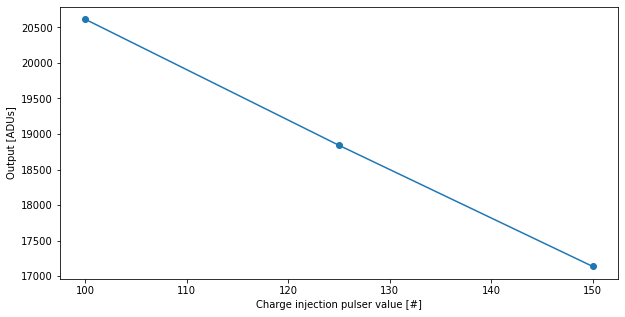

In [52]:
# Fit gain
gain = np.polyfit(ChInjValues, pixelRamp, 1)[0]
print('Gain:{}'.format(gain))

plt.figure(figsize = (10,5))
plt.plot(ChInjValues, pixelRamp,marker='o')
plt.ylabel("Output [ADUs]")
plt.xlabel("Charge injection pulser value [#]")

In [ ]:
# stops the spamming of messages
data = readoutFrames(100)

In [ ]:
# Plot raw data and histogram

dataTimeAvg = np.average(data,axis=2)

print(np.shape(dataTimeAvg))

plt.figure(figsize = (20,10))
plt.imshow(dataTimeAvg, interpolation='none', aspect='auto', origin='lower')
plt.ylabel("Row [#]")
plt.xlabel("Col [#]")
plt.title("Raw data - Avg: {:} - Reference pixel: {:}".format(getMedianDark(data),dataTimeAvg[ref_row,ref_col]))
plt.colorbar()


plt.figure(figsize = (10,5))
plt.hist(data[:,:,0].flatten(), range=[0,2**15],bins=2**8, log=True)
plt.title("Distribution of dark values")
plt.ylabel("Entries [#]")
plt.xlabel("ADC Value [ADUs]")


Noise: 25.704029


Text(0.5, 0, 'Noise [ADUs]')

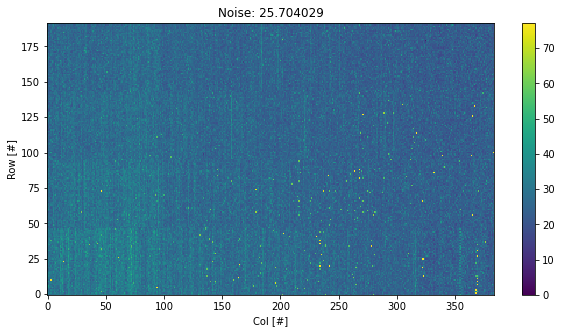

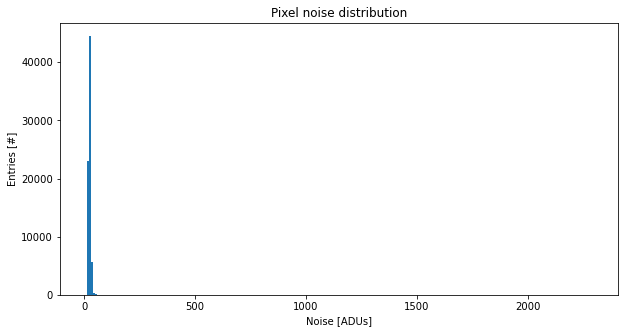

In [57]:
# NOISE

# Uncomment to filter bad pixels!
# data, median_noise = filter_bad_pixels(data)

data_noisemap = np.std(data, axis=2)
median_noise = np.median(data_noisemap)

print('Noise: {:3f}'.format(median_noise))
plt.figure(figsize = (10,5))
plt.imshow(data_noisemap, interpolation='none', aspect='auto', vmin=0, vmax=median_noise*3, origin='lower')
plt.ylabel("Row [#]")
plt.xlabel("Col [#]")
plt.title('Noise: {:3f}'.format(median_noise))
plt.colorbar()

plt.figure(figsize = (10,5))
plt.hist(data_noisemap.flatten(),bins=2**8,)
plt.title("Pixel noise distribution")
plt.ylabel("Entries [#]")
plt.xlabel("Noise [ADUs]")


In [58]:
# Subtract mean and display image
data_darksub = data - np.median(data, axis=2, keepdims=True)

plt.figure(figsize = (20,10))
plt.imshow(data_darksub[:,:,numberOfTriggers-1], interpolation='none', aspect='auto', vmin=-200, vmax=200, origin='lower')
plt.ylabel("Row [#]")
plt.xlabel("Col [#]")
plt.colorbar()

NameError: name 'numberOfTriggers' is not defined

<Figure size 1440x720 with 0 Axes>

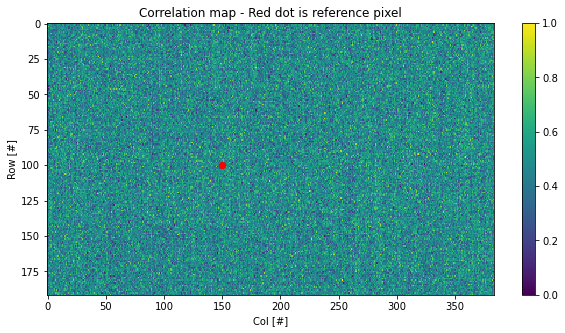

In [26]:
# Plot correlation matrix - Takes some time
correlation = calculate_correlation(data)

plt.figure(figsize = (10,5))
plt.imshow(correlation, interpolation='none', aspect='auto')
plt.scatter(ref_col,ref_row, color='red', s=40)
plt.ylabel("Row [#]")
plt.xlabel("Col [#]")
plt.title('Correlation map - Red dot is reference pixel')
plt.colorbar()

In [27]:
# Disable data debug so it does not store data infinitely and crash software
DEBUG3.cleanData()
print(DEBUG3.getData().shape)
DEBUG3.disableDataDebug()

(192, 384, 0)


AttributeError: 'DataDebug' object has no attribute 'disableDataDebug'

In [ ]:
### Test with parameter scan

DEBUG3.cleanData()
numberOfTriggers = 100

ASIC3.RefinP.set(0)

# For loop over settings
for setting in range(7):

    # Set register
    ASIC3.RefinN.set(setting)
    print('Setting:',setting)
    
    
    for trigNumber in range(numberOfTriggers):
        root.Trigger()
        print("{}".format(trigNumber+1), end='\r')
        time.sleep(0.01)

    # Although the triggers above may have finished, descrambling takes time
    while ( numberOfTriggers != DEBUG3.getData().shape[2]) :
        time.sleep(0.1)
        print("Descrambled {}".format(DEBUG3.getData().shape[2]), end='\r')
    print("Data Descrambled")
    print(DEBUG3.getData().shape)

    # Data format = [row,col,frame_number]
    data = DEBUG3.getData()

    data_noisemap = np.std(data, axis=2)
    median_noise = np.median(data_noisemap)    
    
    print('Noise:',median_noise)
    
    DEBUG3.cleanData()